In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset , DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [81]:
#set random seeds for reproductibility
torch.manual_seed(42)

In [82]:
#check for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device : {device}")

using device : cuda


In [83]:
df = pd.read_csv("/content/fashion-mnist_train.csv")
df.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


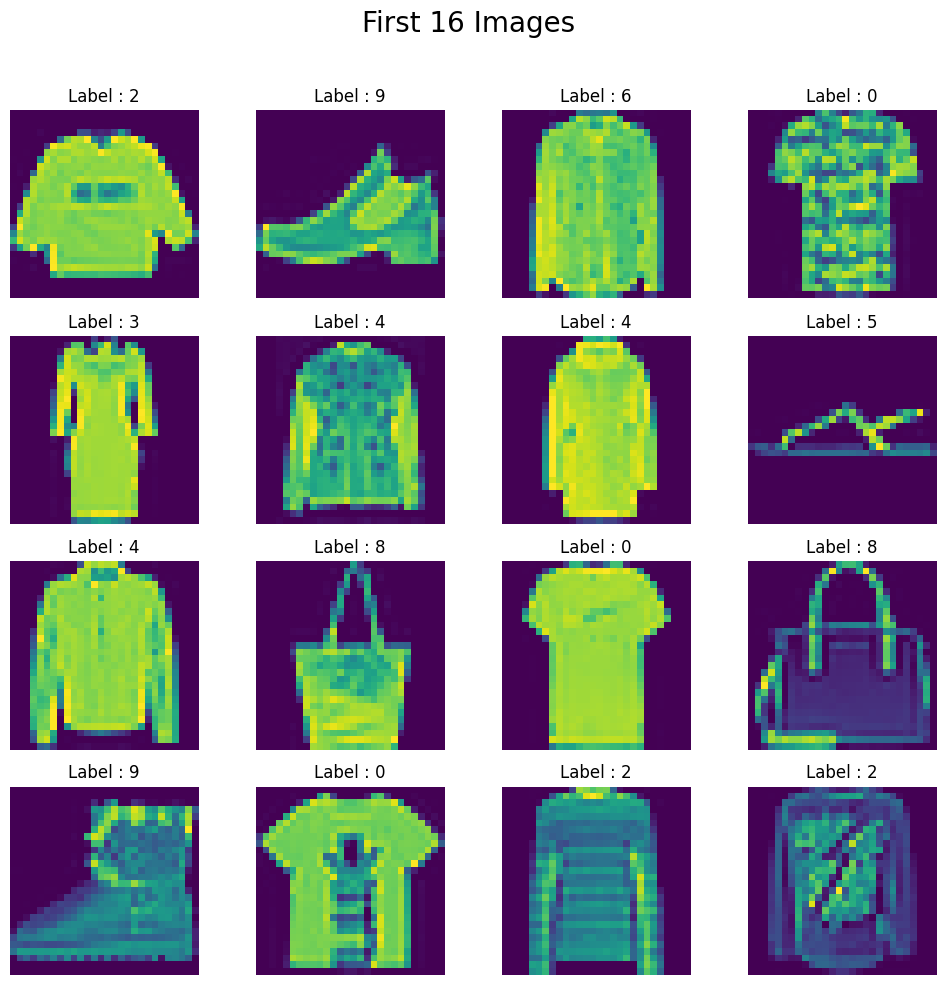

In [84]:
#create a 4x4 grid of images

fig , axes = plt.subplots(4,4, figsize=(10,10))
fig.suptitle("First 16 Images " , fontsize=20)

#plot the first 16 images from the dataset
for i , ax in enumerate(axes.flat):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img )
    ax.axis("off")
    ax.set_title(f"Label : {df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [85]:
#train test split
x= df.iloc[:,1:].values
y = df.iloc[:,0].values

x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.2,random_state=42)


In [106]:
# transformations
from torchvision.transforms import transforms
custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [107]:
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        # Convert flat row to 28x28 grayscale image
        image = self.features[index].reshape(28, 28).astype(np.uint8)

        # Expand grayscale → 3 channels (H, W, C)
        image = np.stack([image] * 3, axis=-1)

        # Convert to PIL Image
        image = Image.fromarray(image)

        # Apply transforms (resize, crop, normalize)
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(self.labels[index], dtype=torch.long)


In [108]:
#create traindataset object
train_dataset = CustomDataset(x_train,y_train , transform = custom_transform)

In [109]:
test_dataset = CustomDataset(x_test,y_test , transform = custom_transform)

In [110]:
train_loader = DataLoader(train_dataset , batch_size = 32 , shuffle = True,pin_memory=True)
test_loader = DataLoader(test_dataset , batch_size = 32 , shuffle = False, pin_memory=True)

In [111]:
#vgg16 model

import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [112]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [113]:
# we Freeze only first two blocks, and  fine-tune rest
for param in vgg16.features[:10].parameters():
    param.requires_grad = False


In [114]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

In [115]:
vgg16 = vgg16.to(device)

In [98]:
learning_rate = 0.0001
epochs = 10

In [116]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=1e-4, weight_decay=1e-4)  # smaller LR + weight decay


In [117]:
epochs = 15

for epoch in range(epochs):
    vgg16.train()
    total_loss = 0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation accuracy
    vgg16.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = vgg16(batch_features)
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Val Acc: {acc:.2f}%")


Epoch [1/15], Loss: 0.3824, Val Acc: 91.12%
Epoch [2/15], Loss: 0.2462, Val Acc: 91.80%


KeyboardInterrupt: 

In [101]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [118]:
# Evaluation on test data
vgg16.eval()   # set model to evaluation mode
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = vgg16(batch_features)



        _, predicted = torch.max(outputs, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


KeyboardInterrupt: 

In [103]:
# Evaluation on training data
vgg16.eval()   # set model to evaluation mode
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = vgg16(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

train_accuracy = 100 * correct / total
print(f"Training Accuracy: {train_accuracy:.2f}%")


0.7003125
